## Initialization

In [1]:
%matplotlib inline
# %load_ext rpy2.ipython
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import spearmanr,ttest_ind, ranksums
from statsmodels.sandbox.stats.multicomp import multipletests
import numpy as np
import matplotlib, leidenalg, os, pickle
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from pca import pca
import igraph as ig
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score,roc_curve, auc
from scipy import interp
import umap
from statannot import add_stat_annotation


format_fig = 'pdf'

def RF_Execute(df,meta, max_iter = 100):
    randomstate = 123
    X_na = (df).copy()

    X=pd.DataFrame()
    for i in meta.unique():
        tempx=(X_na.reindex(meta[meta==i].index))
        X=pd.concat([X,tempx.fillna(tempx.mean())])
    X = X.fillna(0)
    y=meta.reindex(X.index)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=randomstate)
    def RF(it):
        clf=RandomForestClassifier(n_estimators = it,bootstrap = True, oob_score = True, random_state = randomstate)
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        return [it,metrics.accuracy_score(y_test, y_pred),clf.oob_score_]

    select=list(map(RF,range(10,max_iter)))
    select = pd.DataFrame(select, columns=['var', 'accuracy', 'oob']).set_index('var')
    selected = select.sort_values(['accuracy','oob']).drop_duplicates().index[-1]
    clf=RandomForestClassifier(n_estimators = selected,bootstrap = True, oob_score = True, random_state = randomstate)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    thr = 20
    feature_imp = pd.Series(clf.feature_importances_,index=X.columns,name = 'Importance').sort_values(ascending=False)
    feature_imp = feature_imp[feature_imp>0]
    print("Accuracy %d: %f | OOB Score: %f" % (selected,metrics.accuracy_score(y_test, y_pred),clf.oob_score_))
    return feature_imp

class Network_Analysis:
    def __init__(self,raw_data,nodes,respath):
        self.res_path=respath
        self.writer = pd.ExcelWriter('%s/Supplementary Dataset 16N.xlsx' % self.res_path, engine='xlsxwriter')
        self.network_ori=self.__calc(raw_data)
        self.nodes=nodes
        print('Network Analysis')
        self.__net_analysis_combi()
        self.writer.save()
    
    def __calc(self,df):
        print('Calculating Correlation..')
        temp=spearmanr(df.T)
        corr=pd.DataFrame(temp[0],columns=list(df.index),index=list(df.index))
        pval=pd.DataFrame(temp[1],columns=list(df.index),index=list(df.index))
        print('Filtering the matrix Correlation..')
        corr=corr.where(np.triu(np.ones(corr.shape)).astype(np.bool))
        pval=pval.where(np.triu(np.ones(pval.shape)).astype(np.bool))
        print('Making long table of Correlation..')
        corr2=corr.unstack().reset_index(name='weight')
        pval2=pval.unstack().reset_index(name='pval')
        res=corr2.merge(pval2,on=['level_0','level_1'])
        res=res[res['level_0'] != res['level_1']]
        res=res.dropna()
        res=res[['level_0','level_1','weight','pval']]
        res['padj']=multipletests(res['pval'],method='fdr_bh')[1]
        res.columns=['source','target','correlation','pvalue','padj']
        res=res[res.pvalue < 0.05].reset_index(drop=True)
        res.to_excel(self.writer, sheet_name='Edges', index = False)
        print('Done!!')
        return res
    
    def __net_analysis_combi(self):
        print('Loading The Network...')
        temp=self.network_ori
        g= ig.Graph.TupleList(zip(temp['source'],temp['target'],temp['correlation']),weights=True)
        self.network = g
        G_pos = g.subgraph_edges(g.es.select(weight_gt = 0), delete_vertices=False)
        G_neg = g.subgraph_edges(g.es.select(weight_lt = 0), delete_vertices=False)
        G_neg.es['weight'] = [-w for w in G_neg.es['weight']]
        part_pos = leidenalg.ModularityVertexPartition(G_pos, weights='weight')
        part_neg = leidenalg.ModularityVertexPartition(G_neg, weights='weight');
        optimiser = leidenalg.Optimiser()
        diff = optimiser.optimise_partition_multiplex([part_pos, part_neg],layer_weights=[1,-1], n_iterations=-1)
        self.clustering_combi=pd.DataFrame(pd.Series(part_pos.membership+part_neg.membership,index=G_pos.vs['name']+G_neg.vs['name'])).reset_index().drop_duplicates().set_index('index')[0]
        print('Cluster Analysis...')
        self.modularity_combi=diff
        self.nodes['cluster'] = self.clustering_combi.reindex(self.nodes.index).tolist()
        temp = pd.Series(self.network.degree(),index = self.network.vs['name'],name='Degree').reindex(self.nodes.index)
        self.nodes = pd.concat([self.nodes,temp],1)
        self.nodes.to_excel(self.writer, sheet_name='Nodes')
    
    def save_network(self):
        print('Saving The Network..')
        pickle_out = open('%s/network_object.pkl' % self.res_path,"wb")
        self.writer = None
        pickle.dump(self, pickle_out)
        pickle_out.close()

## Clinical and Physical Data

In [ ]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
data = temp.iloc[0:,5:]
metadata = temp['Liver Fat Class']

In [ ]:
low = data.reindex(metadata[metadata == 'Mild'].index)
moderate = data.reindex(metadata[metadata == 'Moderate'].index)
strong = data.reindex(metadata[metadata == 'Severe'].index)

zero = data.reindex(metadata[metadata == 'None'].index)

res = []

for i in data.columns:
    templ = ttest_ind(low[i].dropna(),zero[i].dropna())[1]
    tempm = ttest_ind(moderate[i].dropna(),zero[i].dropna())[1]
    temps = ttest_ind(strong[i].dropna(),zero[i].dropna())[1]
    res.append([i,np.log2(low[i].mean()/zero[i].mean()),np.log2(moderate[i].mean()/zero[i].mean()),np.log2(strong[i].mean()/zero[i].mean()),templ,tempm,temps])

res = pd.DataFrame(res,columns=['Measurements','Log2FoldChange (Mild vs None)','Log2FoldChange (Moderate vs None)','Log2FoldChange (Severe vs None)', 'P value (Mild vs None)', 'P value (Moderate vs None)','P value (Severe vs None)']).set_index('Measurements')
res.to_excel('../ResultsPaper/DS/Supplementary Dataset 1N_1D.xlsx')

In [ ]:
pval=res[res.columns[res.columns.str.contains('P value')]]
var=pval[pval<0.05].dropna(how='all').index.tolist()
data_1d=data[var[1:]].reindex(metadata.index)
data_1d=data_1d.fillna(data_1d.mean())
data_1d.index=metadata.tolist()

model = pca(n_components=2)
results = model.fit_transform(np.log10(data_1d))

col_dict=dict(zip(data_1d.index.unique(),sns.color_palette("Paired")))
color=(col_dict[i] for i in data_1d.index)

fig,ax=plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax,data=model.results['PC'].reset_index(),x='PC1',y='PC2',hue='index',s=700,palette="tab20",hue_order=['None','Mild','Moderate','Severe'])
ax.set_xlabel('PC1 (%.2f%%)' % (model.results['explained_var'][0]*100))
ax.set_ylabel('PC2 (%.2f%%)' % ((model.results['explained_var'][1]-model.results['explained_var'][0])*100))
loadings=model.results['loadings']
for i in loadings.columns:
    temp=loadings[i].tolist()
    ax.arrow(0,0,temp[0],temp[1], head_width=0.01, fc='k', ec='k')
    ax.text(temp[0],temp[1],i)
plt.ylim(ax.get_ylim()[0],1)
plt.legend(loc='upper left')
# plt.savefig('../ResultsPaper/Figures/1d.'+format_fig)

## Metagenomics

In [ ]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
metadata = temp['Liver Fat Class']

In [ ]:
temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 3N.xlsx')
temp.sheet_names
data_gut = temp.parse('Abundance_Gut',index_col=0)
data_gut[data_gut <=0] = 10E-4
data_gut = data_gut[data_gut.index.str.contains('\|s__')].dropna(how = 'all').T
data_gut.columns = [i.split('|')[-1][3:] for i in data_gut.columns]
metadata_gut = metadata.reindex(data_gut.index)

data_oral = temp.parse('Abundance_Oral',index_col=0)
data_oral[data_oral <=0] = 10E-4
data_oral = data_oral[data_oral.index.str.contains('\|s__')].dropna(how = 'all').T
data_oral.columns = [i.split('|')[-1][3:] for i in data_oral.columns]
metadata_oral = metadata.reindex(data_oral.index)


In [ ]:
writer = pd.ExcelWriter('../ResultsPaper/DS/Supplementary Dataset 4N.xlsx', engine='xlsxwriter')

low = data_gut.reindex(metadata_gut[metadata_gut == 'Mild'].index)
moderate = data_gut.reindex(metadata_gut[metadata_gut == 'Moderate'].index)
strong = data_gut.reindex(metadata_gut[metadata_gut == 'Severe'].index)
zero = data_gut.reindex(metadata_gut[metadata_gut == 'None'].index)

res = []

for i in data_gut.columns:
    templ = ranksums(low[i],zero[i])[1]
    tempm = ranksums(moderate[i],zero[i])[1]
    temps = ranksums(strong[i],zero[i])[1]
    res.append([i,np.log2(low[i].mean()/zero[i].mean()),np.log2(moderate[i].mean()/zero[i].mean()),np.log2(strong[i].mean()/zero[i].mean()),templ,tempm,temps])

res = pd.DataFrame(res,columns=['Microbe','Log2FoldChange (Mild vs None)','Log2FoldChange (Moderate vs None)','Log2FoldChange (Severe vs None)','P value (Mild vs None)', 'P value (Moderate vs None)','P value (Severe vs None)']).set_index('Microbe')
res.dropna(how = 'all').to_excel(writer, sheet_name='Gut')

low = data_oral.reindex(metadata_oral[metadata_oral == 'Mild'].index)
moderate = data_oral.reindex(metadata_oral[metadata_oral == 'Moderate'].index)
strong = data_oral.reindex(metadata_oral[metadata_oral == 'Severe'].index)
zero = data_oral.reindex(metadata_oral[metadata_oral == 'None'].index)

res = []

for i in data_oral.columns:
    templ = ranksums(low[i],zero[i])[1]
    tempm = ranksums(moderate[i],zero[i])[1]
    temps = ranksums(strong[i],zero[i])[1]
    res.append([i,np.log2(low[i].mean()/zero[i].mean()),np.log2(moderate[i].mean()/zero[i].mean()),np.log2(strong[i].mean()/zero[i].mean()),templ,tempm,temps])

res = pd.DataFrame(res,columns=['Microbe','Log2FoldChange (Mild vs None)','Log2FoldChange (Moderate vs None)','Log2FoldChange (Severe vs None)','P value (Mild vs None)', 'P value (Moderate vs None)','P value (Severe vs None)']).set_index('Microbe')
res.dropna(how = 'all').to_excel(writer, sheet_name='Oral')

writer.save()

In [ ]:
var = ['Liver fat (%)',
 'Creatinine (mg/dL)',
 'Uric acid (mg/dL)',
 'ALT (IU/L)',
 'AST (IU/L)',
 'GGT (U/L)',
 'Albumin (g/dL)',
 'Creatine Kinase (U/L)',
 'Right arm fat free mass (kg/m2)']

temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
data_clin = temp.iloc[0:,5:]

writer = pd.ExcelWriter('../ResultsPaper/DS/Supplementary Dataset 5N.xlsx', engine='xlsxwriter')


res_dict = {}
for i in var:
    temp_data = pd.concat([data_clin[i],data_gut],1)
    x = []
    for j in data_gut.columns:
        temp = spearmanr(temp_data[i],temp_data[j],nan_policy='omit')
        x.append([j,temp[0],temp[1]])
    temp = pd.DataFrame(x,columns = ['Metabolites','Correlation','P-Value']).set_index('Metabolites')
    res_dict[i] = temp
pd.concat(res_dict,axis = 1).to_excel(writer, sheet_name='Gut')

res_dict = {}
for i in var:
    temp_data = pd.concat([data_clin[i],data_oral],1)
    x = []
    for j in data_oral.columns:
        temp = spearmanr(temp_data[i],temp_data[j],nan_policy='omit')
        x.append([j,temp[0],temp[1]])
    temp = pd.DataFrame(x,columns = ['Metabolites','Correlation','P-Value']).set_index('Metabolites')
    res_dict[i] = temp
pd.concat(res_dict,axis = 1).to_excel(writer, sheet_name='Oral')

writer.save()

## Gut and Oral Metagenomics Correlations

In [ ]:
temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 3N.xlsx')

data_gut = temp.parse('Abundance_Gut',index_col=0)
data_gut[data_gut <= 1] = np.nan
data_gut = data_gut[data_gut.index.str.contains('\|s__')].dropna(how = 'all').T
data_gut.columns = [i.split('|')[-1][3:] for i in data_gut.columns]
metadata_gut = metadata.reindex(data_gut.index)

data_oral = temp.parse('Abundance_Oral',index_col=0)
data_oral[data_oral <= 1] = np.nan
data_oral = data_oral[data_oral.index.str.contains('\|s__')].dropna(how = 'all').T
data_oral.columns = [i.split('|')[-1][3:] for i in data_oral.columns]
metadata_oral = metadata.reindex(data_oral.index)


x = {}
for i in data_gut.columns:
    t1 = data_gut[i]
    y = []
    for j in data_oral.columns:
        t2 = data_oral.reindex(data_gut.index)[j]
        if pd.concat([t1,t2],1).dropna().shape[0] < 5:
            continue
        temp = spearmanr(t1,t2,nan_policy='omit')
        y.append([j,temp[0],temp[1]])
    y = pd.DataFrame(y,columns=['Oral','Correlation','P-Value'])
    if y.shape[0] == 0:
        continue
    x[i] = y.set_index('Oral')
res = pd.concat(x,axis = 1, keys=x.keys())

res.to_excel('../ResultsPaper/DS/Supplementary Dataset 6N.xlsx')

corr = pd.DataFrame()
pval = pd.DataFrame()

for i in res.columns.levels[0]:
    temp = res[i]
    corr = pd.concat([corr,temp['Correlation']],1).rename(columns = {'Correlation': i})
    pval = pd.concat([pval,temp['P-Value']],1).rename(columns = {'P-Value': i})

pval[pval > 0.05] = np.nan
pval[pval.notna()] = '*'
pval = pval.dropna(how='all', axis = 0).dropna(how='all', axis = 1)

In [ ]:
temp_sel = pval.copy().T
temp_corr = corr.loc[temp_sel.columns,temp_sel.index].T
cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0000a5",'#0000d8',"#FFFAF0",'#d80000',"#a50000"])
g= sns.clustermap(temp_corr.fillna(0), figsize = (10,7),center = 0, cmap = cmap,xticklabels = 1, yticklabels = 1, annot=temp_sel.fillna(''),annot_kws={"size": 15,"ha": 'center',"va": 'center'},fmt='s', vmin=-1, vmax=1)
g.savefig('../ResultsPaper/Figures/Figure 3C.pdf')

## Metabolomics

In [ ]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
metadata = temp['Liver Fat Class']

In [ ]:
temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 7N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Metabolomics']
avail = avail[avail == 'YES']
data_all = temp.parse('Raw Metabolomics Data',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]
mapping_pw = data_all.iloc[0:,0:11]

#remove metabolites with > 50% NA
data = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T

In [ ]:
low = data.reindex(metadata[metadata == 'Mild'].index)
moderate = data.reindex(metadata[metadata == 'Moderate'].index)
strong = data.reindex(metadata[metadata == 'Severe'].index)
zero = data.reindex(metadata[metadata == 'None'].index)

res = []

for i in data.columns:
    templ = ttest_ind(low[i].dropna(),zero[i].dropna())[1]
    tempm = ttest_ind(moderate[i].dropna(),zero[i].dropna())[1]
    temps = ttest_ind(strong[i].dropna(),zero[i].dropna())[1]
    res.append([i,np.log2(low[i].mean()/zero[i].mean()),np.log2(moderate[i].mean()/zero[i].mean()),np.log2(strong[i].mean()/zero[i].mean()),templ,tempm,temps])

res = pd.DataFrame(res,columns=['Metabolite','Log2FoldChange (Mild vs None)','Log2FoldChange (Moderate vs None)','Log2FoldChange (Severe vs None)','P value (Mild vs None)', 'P value (Moderate vs None)','P value (Severe vs None)']).set_index('Metabolite')
res=pd.concat([mapping_pw.reindex(res.index),res],1)
res.to_excel('../ResultsPaper/DS/Supplementary Dataset 8N.xlsx')

In [ ]:
var = ['Liver fat (%)',
 'Creatinine (mg/dL)',
 'Uric acid (mg/dL)',
 'ALT (IU/L)',
 'AST (IU/L)',
 'GGT (U/L)',
 'Albumin (g/dL)',
 'Creatine Kinase (U/L)',
 'Right arm fat free mass (kg/m2)']

temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
data_clin = temp.iloc[0:,5:]


res_dict = {}
for i in var:
    temp_data = pd.concat([data_clin[i],data],1)
    x = []
    for j in data.columns:
        temp = spearmanr(temp_data[i],temp_data[j],nan_policy='omit')
        x.append([j,temp[0],temp[1]])
    temp = pd.DataFrame(x,columns = ['Metabolites','Correlation','P-Value']).set_index('Metabolites')
    res_dict[i] = temp
pd.concat(res_dict,axis = 1).to_excel('../ResultsPaper/DS/Supplementary Dataset 9N.xlsx')

## Proteomics

In [ ]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
metadata = temp['Liver Fat Class']

In [ ]:
temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 10N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Proteomics']
avail = avail[avail == 'YES'] 
data_all = temp.parse('NPX Values',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]

#remove proteins with > 50% NA
data = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T

In [ ]:
low = data.reindex(metadata[metadata == 'Mild'].index)
moderate = data.reindex(metadata[metadata == 'Moderate'].index)
strong = data.reindex(metadata[metadata == 'Severe'].index)
zero = data.reindex(metadata[metadata == 'None'].index)

res = []

for i in data.columns:
    templ = ttest_ind(low[i].dropna(),zero[i].dropna())[1]
    tempm = ttest_ind(moderate[i].dropna(),zero[i].dropna())[1]
    temps = ttest_ind(strong[i].dropna(),zero[i].dropna())[1]
    res.append([i,np.log2(low[i].mean()/zero[i].mean()),np.log2(moderate[i].mean()/zero[i].mean()),np.log2(strong[i].mean()/zero[i].mean()),templ,tempm,temps])

res = pd.DataFrame(res,columns=['Protein','Log2FoldChange (Mild vs None)','Log2FoldChange (Moderate vs None)','Log2FoldChange (Severe vs None)','P value (Mild vs None)', 'P value (Moderate vs None)','P value (Severe vs None)']).set_index('Protein')
res.to_excel('../ResultsPaper/DS/Supplementary Dataset 11N.xlsx')

In [ ]:
var = ['Liver fat (%)',
 'Creatinine (mg/dL)',
 'Uric acid (mg/dL)',
 'ALT (IU/L)',
 'AST (IU/L)',
 'GGT (U/L)',
 'Albumin (g/dL)',
 'Creatine Kinase (U/L)',
 'Right arm fat free mass (kg/m2)']

temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
data_clin = temp.iloc[0:,5:]

res_dict = {}
for i in var:
    temp_data = pd.concat([data_clin[i],data],1)
    x = []
    for j in data.columns:
        temp = spearmanr(temp_data[i],temp_data[j],nan_policy='omit')
        x.append([j,temp[0],temp[1]])
    temp = pd.DataFrame(x,columns = ['Metabolites','Correlation','P-Value']).set_index('Metabolites')
    temp['FDR']=multipletests(temp['P-Value'],method='fdr_bh')[1]
    res_dict[i] = temp
pd.concat(res_dict,axis = 1).to_excel('../ResultsPaper/DS/Supplementary Dataset 12N.xlsx')

## Class Comparison

In [ ]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
metadata = temp['Liver Fat Class']

In [ ]:
temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 3N.xlsx')
temp.sheet_names
data_gut = temp.parse('Abundance_Gut',index_col=0)
data_gut = data_gut[data_gut.index.str.contains('\|c__') & ~data_gut.index.str.contains('\|f__') & ~data_gut.index.str.contains('\|o__')].dropna(how = 'all').T
data_gut.columns = [i.split('|')[-1][3:] for i in data_gut.columns]
metadata_gut = metadata.reindex(data_gut.index)

data_oral = temp.parse('Abundance_Oral',index_col=0)
data_oral = data_oral[data_oral.index.str.contains('\|c__') & ~data_oral.index.str.contains('\|f__') & ~data_oral.index.str.contains('\|o__')].dropna(how = 'all').T
data_oral.columns = [i.split('|')[-1][3:] for i in data_oral.columns]
metadata_oral = metadata.reindex(data_oral.index)


In [ ]:
temp = pd.concat([data_gut,metadata_gut],1).groupby('Liver Fat Class').mean()
temp = (temp.T*100/temp.sum(1))
temp = temp[temp>1].dropna(how='all')[['None','Mild', 'Moderate', 'Severe']]
temp.loc['Others'] = 100 - temp.sum()
temp = temp.sort_values(['None','Mild', 'Moderate', 'Severe'][::-1], ascending = False)
temp.T.plot(kind='bar', stacked=True,cmap = 'tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Abundance')
plt.tight_layout()
plt.savefig('../ResultsPaper/Figures/Figure 2C.pdf')

In [ ]:
temp = pd.concat([data_oral,metadata_oral],1).groupby('Liver Fat Class').mean()
temp = (temp.T*100/temp.sum(1))
temp = temp[temp>1].dropna(how='all')[['None','Mild', 'Moderate', 'Severe']]
temp.loc['Others'] = 100 - temp.sum()
temp = temp.sort_values(['None','Mild', 'Moderate', 'Severe'][::-1], ascending = False)
temp.T.plot(kind='bar', stacked=True,cmap = 'tab20')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Abundance')
plt.tight_layout()
plt.savefig('../ResultsPaper/Figures/Figure 2D.pdf')

## Gut and Oral vs Proteomics and Metabolomics

In [ ]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
metadata = temp['Liver Fat Class']

In [ ]:
temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 3N.xlsx')

data_gut = temp.parse('Abundance_Gut',index_col=0)
data_gut[data_gut <= 1] = np.nan
data_gut = data_gut[data_gut.index.str.contains('\|s__')].dropna(how = 'all').T
data_gut.columns = [i.split('|')[-1][3:] for i in data_gut.columns]
metadata_gut = metadata.reindex(data_gut.index)

data_oral = temp.parse('Abundance_Oral',index_col=0)
data_oral[data_oral <= 1] = np.nan
data_oral = data_oral[data_oral.index.str.contains('\|s__')].dropna(how = 'all').T
data_oral.columns = [i.split('|')[-1][3:] for i in data_oral.columns]
metadata_oral = metadata.reindex(data_oral.index)

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 10N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Proteomics']
avail = avail[avail == 'YES'] 
data_all = temp.parse('NPX Values',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]

#remove proteins with > 50% NA
data_prot = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 7N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Metabolomics']
avail = avail[avail == 'YES']
data_all = temp.parse('Raw Metabolomics Data',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]
mapping_pw = data_all.iloc[0:,0:11]

#remove metabolites with > 50% NA
data_met = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T



In [ ]:
x = {}
for i in data_gut.columns:
    t1 = data_gut[i]
    y = []
    for j in data_met.columns:
        t2 = data_met.reindex(data_gut.index)[j]
        if pd.concat([t1,t2],1).dropna().shape[0] < 5:
            continue
        temp = spearmanr(t1,t2,nan_policy='omit')
        y.append([j,temp[0],temp[1]])
    y = pd.DataFrame(y,columns=['Metabolites','Correlation','P-Value'])
    if y.shape[0] == 0:
        continue
    x[i] = y.set_index('Metabolites')
res_gut = pd.concat(x,axis = 1, keys=x.keys())

x = {}
for i in data_oral.columns:
    t1 = data_oral[i]
    y = []
    for j in data_met.columns:
        t2 = data_met.reindex(data_oral.index)[j]
        if pd.concat([t1,t2],1).dropna().shape[0] < 5:
            continue
        temp = spearmanr(t1,t2,nan_policy='omit')
        y.append([j,temp[0],temp[1]])
    y = pd.DataFrame(y,columns=['Metabolites','Correlation','P-Value'])
    if y.shape[0] == 0:
        continue
    x[i] = y.set_index('Metabolites')
res_oral = pd.concat(x,axis = 1, keys=x.keys())

writer = pd.ExcelWriter('../ResultsPaper/DS/Supplementary Dataset 13N.xlsx')
res_gut.to_excel(writer, sheet_name = 'Gut')
res_oral.to_excel(writer, sheet_name = 'Oral')
writer.save()

In [ ]:
temp = pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 13N.xlsx')
res_oral = temp.parse('Oral',index_col = 0, header = [0,1])
res_gut = temp.parse('Gut',index_col = 0, header = [0,1])

In [ ]:
res = res_oral.copy()
corr = pd.DataFrame()
pval = pd.DataFrame()

for i in res.columns.levels[0]:
    temp = res[i]
    corr = pd.concat([corr,temp['Correlation']],1).rename(columns = {'Correlation': i})
    pval = pd.concat([pval,temp['P-Value']],1).rename(columns = {'P-Value': i})
pval[pval > 0.05] = np.nan
pval[pval.notna()] = '*'
pval = pval.dropna(how='all', axis = 0).dropna(how='all', axis = 1)

temp_sel = pval.copy().T
temp_sel = temp_sel.T[temp_sel.notna().sum() >= 5].T.dropna(how = 'all')
temp_corr = corr.loc[temp_sel.columns,temp_sel.index].T

cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0000a5",'#0000d8',"#FFFAF0",'#d80000',"#a50000"])
g= sns.clustermap(temp_corr.fillna(0), figsize = (20,15),center = 0, cmap = cmap,xticklabels = 1, yticklabels = 1, annot=temp_sel.fillna(''),annot_kws={"size": 15,"ha": 'center',"va": 'center'},fmt='s', vmin=-1, vmax=1)
g.savefig('../ResultsPaper/Figures/Figure S2.pdf')

In [ ]:
res = res_gut.copy()
corr = pd.DataFrame()
pval = pd.DataFrame()

for i in res.columns.levels[0]:
    temp = res[i]
    corr = pd.concat([corr,temp['Correlation']],1).rename(columns = {'Correlation': i})
    pval = pd.concat([pval,temp['P-Value']],1).rename(columns = {'P-Value': i})

pval[pval > 0.05] = np.nan
pval[pval.notna()] = '*'
pval = pval.dropna(how='all', axis = 0).dropna(how='all', axis = 1)
temp_sel = pval.copy().T
temp_sel = temp_sel.T[temp_sel.notna().sum() >= 5].T.dropna(how = 'all')
temp_corr = corr.loc[temp_sel.columns,temp_sel.index].T

cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0000a5",'#0000d8',"#FFFAF0",'#d80000',"#a50000"])
g= sns.clustermap(temp_corr.fillna(0), figsize = (10,10),center = 0, cmap = cmap,xticklabels = 1, yticklabels = 1, annot=temp_sel.fillna(''),annot_kws={"size": 15,"ha": 'center',"va": 'center'},fmt='s', vmin=-1, vmax=1)
g.savefig('../ResultsPaper/Figures/Figure S3.pdf')

In [ ]:
x = {}
for i in data_gut.columns:
    t1 = data_gut[i]
    y = []
    for j in data_prot.columns:
        t2 = data_prot.reindex(data_gut.index)[j]
        if pd.concat([t1,t2],1).dropna().shape[0] < 5:
            continue
        temp = spearmanr(t1,t2,nan_policy='omit')
        y.append([j,temp[0],temp[1]])
    y = pd.DataFrame(y,columns=['Proteins','Correlation','P-Value'])
    if y.shape[0] == 0:
        continue
    x[i] = y.set_index('Proteins')
res_gut = pd.concat(x,axis = 1, keys=x.keys())

x = {}
for i in data_oral.columns:
    t1 = data_oral[i]
    y = []
    for j in data_prot.columns:
        t2 = data_prot.reindex(data_oral.index)[j]
        if pd.concat([t1,t2],1).dropna().shape[0] < 5:
            continue
        temp = spearmanr(t1,t2,nan_policy='omit')
        y.append([j,temp[0],temp[1]])
    y = pd.DataFrame(y,columns=['Proteins','Correlation','P-Value'])
    if y.shape[0] == 0:
        continue
    x[i] = y.set_index('Proteins')
res_oral = pd.concat(x,axis = 1, keys=x.keys())

writer = pd.ExcelWriter('../ResultsPaper/DS/Supplementary Dataset 14N.xlsx')
res_gut.to_excel(writer, sheet_name = 'Gut')
res_oral.to_excel(writer, sheet_name = 'Oral')
writer.save()


In [ ]:
temp = pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 14N.xlsx')
res_oral = temp.parse('Oral',index_col = 0, header = [0,1])
res_gut = temp.parse('Gut',index_col = 0, header = [0,1])

In [ ]:
res = res_oral.copy()
corr = pd.DataFrame()
pval = pd.DataFrame()

for i in res.columns.levels[0]:
    temp = res[i]
    corr = pd.concat([corr,temp['Correlation']],1).rename(columns = {'Correlation': i})
    pval = pd.concat([pval,temp['P-Value']],1).rename(columns = {'P-Value': i})
pval[pval > 0.05] = np.nan
pval[pval.notna()] = '*'
pval = pval.dropna(how='all', axis = 0).dropna(how='all', axis = 1)
temp_sel = pval.copy().T
temp_corr = corr.loc[temp_sel.columns,temp_sel.index].T

cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0000a5",'#0000d8',"#FFFAF0",'#d80000',"#a50000"])
g= sns.clustermap(temp_corr.fillna(0), figsize = (15,10),center = 0, cmap = cmap,xticklabels = 1, yticklabels = 1, annot=temp_sel.fillna(''),annot_kws={"size": 15,"ha": 'center',"va": 'center'},fmt='s', vmin=-1, vmax=1)
g.savefig('../ResultsPaper/Figures/Figure S4.pdf')

In [ ]:
res = res_gut.copy()
corr = pd.DataFrame()
pval = pd.DataFrame()

for i in res.columns.levels[0]:
    temp = res[i]
    corr = pd.concat([corr,temp['Correlation']],1).rename(columns = {'Correlation': i})
    pval = pd.concat([pval,temp['P-Value']],1).rename(columns = {'P-Value': i})
pval[pval > 0.05] = np.nan
pval[pval.notna()] = '*'
pval = pval.dropna(how='all', axis = 0).dropna(how='all', axis = 1)
temp_sel = pval.copy().T
temp_corr = corr.loc[temp_sel.columns,temp_sel.index].T

cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0000a5",'#0000d8',"#FFFAF0",'#d80000',"#a50000"])
g= sns.clustermap(temp_corr.fillna(0), figsize = (15,7),center = 0, cmap = cmap,xticklabels = 1, yticklabels = 1, annot=temp_sel.fillna(''),annot_kws={"size": 15,"ha": 'center',"va": 'center'},fmt='s', vmin=-1, vmax=1)
g.savefig('../ResultsPaper/Figures/Figure S5.pdf')

## Candidate Biomarkers Identification

In [ ]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
data_clin = temp.iloc[0:,5:]
metadata = temp['Liver Fat Class']

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 7N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Metabolomics']
avail = avail[avail == 'YES']
data_all = temp.parse('Raw Metabolomics Data',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]
mapping_pw = data_all.iloc[0:,0:11]

#remove metabolites with > 50% NA
data_met = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 10N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Proteomics']
avail = avail[avail == 'YES'] 
data_all = temp.parse('NPX Values',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]

#remove proteins with > 50% NA
data_prot = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T

samples_intersect = set(data_prot.index).intersection(set(data_met.index)).intersection(set(data_clin.index))
data = pd.concat([data_clin.reindex(samples_intersect), data_met.reindex(samples_intersect), data_prot.reindex(samples_intersect)],1)
del data['Liver fat (%)']


metadata = metadata.reindex(samples_intersect)

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 3N.xlsx')
temp.sheet_names
data_gut = temp.parse('Abundance_Gut',index_col=0)
data_gut = data_gut[data_gut.index.str.contains('\|s__')].dropna(how = 'all').T
data_gut.columns = [i.split('|')[-1][3:]+' (GUT)' for i in data_gut.columns]

data_oral = temp.parse('Abundance_Oral',index_col=0)
data_oral = data_oral[data_oral.index.str.contains('\|s__')].dropna(how = 'all').T
data_oral.columns = [i.split('|')[-1][3:]+' (ORAL)' for i in data_oral.columns]

samples_intersect = set(data_oral.index).intersection(set(data_gut.index))
data_microb = pd.concat([data_oral.reindex(samples_intersect),data_gut.reindex(samples_intersect)],1).fillna(0)

In [ ]:
stats_clin = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N_1D.xlsx',index_col=0)
stats_clin = stats_clin[stats_clin.columns[stats_clin.columns.str.contains(' vs ')]]
stats_clin['Location'] = 'CLINICAL'

stats_met = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 8N.xlsx',index_col=0)
stats_met = stats_met[stats_met.columns[stats_met.columns.str.contains(' vs ')]]#.iloc[0:,0:-3]
stats_met['Location'] = 'METABOLITE'

stats_prot = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 11N.xlsx',index_col=0)
stats_prot = stats_prot[stats_prot.columns[stats_prot.columns.str.contains(' vs ')]]
stats_prot['Location'] = 'PROTEIN'


stats_gut = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 4N.xlsx',index_col=0, sheet_name='Gut')
stats_gut = stats_gut[stats_gut.columns[stats_gut.columns.str.contains(' vs ')]]
stats_gut.index = stats_gut.index + ' (GUT)'
stats_gut['Location'] = 'GUT'


stats_oral = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 4N.xlsx',index_col=0, sheet_name='Oral')
stats_oral = stats_oral[stats_oral.columns[stats_oral.columns.str.contains(' vs ')]]
stats_oral.index = stats_oral.index + ' (ORAL)'
stats_oral['Location'] = 'ORAL'

stats_all = pd.concat([stats_clin, stats_met, stats_prot,stats_oral,stats_gut])

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 7N.xlsx')
mapping_pw = temp.parse('Raw Metabolomics Data',index_col=0).iloc[0:,0:2]

In [ ]:
randomstate = 123

writer = pd.ExcelWriter('../ResultsPaper/DS/Supplementary Dataset 15N.xlsx', engine='xlsxwriter')

print('Clinical (C) (ALL):')
RF_clin = RF_Execute(data_clin.iloc[0:,1:],metadata)
RF_clin=pd.concat([RF_clin,stats_clin.reindex(RF_clin.index)],1)
RF_clin.to_excel(writer, sheet_name='Clinical')

print('Metabolomics (M) (ALL):')
RF_met = RF_Execute(data_met,metadata)
RF_met=pd.concat([RF_met,mapping_pw.reindex(RF_met.index),stats_met.reindex(RF_met.index)],1)
RF_met.to_excel(writer, sheet_name='Metabolites')

print('Proteomics (P) (ALL):')
RF_prot = RF_Execute(data_prot,metadata)
RF_prot=pd.concat([RF_prot,stats_prot.reindex(RF_prot.index)],1)
RF_prot.to_excel(writer, sheet_name='Proteins')

print('Gut (G) (ALL):')
RF_gut = RF_Execute(data_gut,metadata)
RF_gut=pd.concat([RF_gut,stats_gut.reindex(RF_gut.index)],1)
RF_gut.to_excel(writer, sheet_name='Gut')

print('Oral (O) (ALL):')
RF_oral = RF_Execute(data_oral,metadata)
RF_oral=pd.concat([RF_oral,stats_oral.reindex(RF_oral.index)],1)
RF_oral.to_excel(writer, sheet_name='Oral')

var = RF_clin.iloc[0:5].index.tolist()
print('C(5):')
RF = RF_Execute(data[var],metadata)
RF = pd.concat([RF,pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(5)')

var = RF_clin.iloc[0:10].index.tolist()
print('C(10):')
RF = RF_Execute(data[var],metadata)
RF = pd.concat([RF,pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(10)')

var = RF_met.iloc[0:5].index.tolist()
print('M(5):')
RF = RF_Execute(data[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='M(5)')

var = RF_met.iloc[0:10].index.tolist()
print('M(10):')
RF = RF_Execute(data[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='M(10)')

var = RF_prot.iloc[0:5].index.tolist()
print('P(5):')
RF = RF_Execute(data[var],metadata)
RF = pd.concat([RF,pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='P(5)')

var = RF_prot.iloc[0:10].index.tolist()
print('P(10):')
RF = RF_Execute(data[var],metadata)
RF = pd.concat([RF,pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='P(10)')

var = RF_gut[0:5].index.tolist()
print('G(5):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='G(5)')

var = RF_gut[0:10].index.tolist()
print('G(10):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='G(10)')

var = RF_oral[0:5].index.tolist()
print('O(5):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='O(5)')


var = RF_oral[0:10].index.tolist()
print('O(10):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='O(10)')

print('C + M + P + G + O (ALL):')
RF = RF_Execute(pd.concat([data,data_oral.dropna(how='all',axis = 1).fillna(0),data_gut.dropna(how='all',axis = 1).fillna(0)],1),metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C + M + P + G + O (ALL)')

var = RF_clin.iloc[0:5].index.tolist()+RF_met.iloc[0:10].index.tolist()+RF_prot.iloc[0:5].index.tolist()
print('C(5) + M(10) + P(5):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(5) + M(10) + P(5)')

var = RF_clin.iloc[0:5].index.tolist()+RF_met.iloc[0:10].index.tolist()+RF_prot.iloc[0:5].index.tolist()+RF_gut[0:10].index.tolist()
print('C(5) + M(10) + P(5) + G(10):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(5) + M(10) + P(5) + G(10)')

var = RF_clin.iloc[0:5].index.tolist()+RF_met.iloc[0:10].index.tolist()+RF_prot.iloc[0:5].index.tolist()+RF_oral[0:10].index.tolist()
print('C(5) + M(10) + P(5) + O(10):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(5) + M(10) + P(5) + O(10)')

var = RF_clin.iloc[0:5].index.tolist()+RF_met.iloc[0:10].index.tolist()+RF_prot.iloc[0:5].index.tolist()+RF_gut[0:10].index.tolist()+RF_oral[0:10].index.tolist()
print('C(5) + M(10) + P(5) + G(10) + O(10):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(5)+M(10)+P(5)+G(10)+O(10)')

var = RF_clin.iloc[0:5].index.tolist()+RF_met.iloc[0:5].index.tolist()+RF_prot.iloc[0:5].index.tolist()
print('C(5) + M(5) + P(5):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(5) + M(5) + P(5)')

var = RF_clin.iloc[0:5].index.tolist()+RF_met.iloc[0:5].index.tolist()+RF_prot.iloc[0:5].index.tolist()+RF_gut[0:5].index.tolist()
print('C(5) + M(5) + P(5) + G(5):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(5) + M(5) + P(5)')

var = RF_clin.iloc[0:5].index.tolist()+RF_met.iloc[0:5].index.tolist()+RF_prot.iloc[0:5].index.tolist()+RF_oral[0:5].index.tolist()
print('C(5) + M(5) + P(5) + O(5):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(5) + M(5) + P(5) + O(5)')

var = RF_clin.iloc[0:5].index.tolist()+RF_met.iloc[0:5].index.tolist()+RF_prot.iloc[0:5].index.tolist()+RF_gut[0:5].index.tolist()+RF_oral[0:5].index.tolist()
print('C(5) + M(5) + P(5) + G(5) + O(5):')
RF = RF_Execute(pd.concat([data,data_microb],1)[var],metadata)
RF = pd.concat([RF,mapping_pw.reindex(RF.index),pd.concat([stats_all,],1).reindex(RF.index)],1)
RF.to_excel(writer, sheet_name='C(5)+M(5)+P(5)+G(5)+O(5)')

writer.save()

## ROC

In [ ]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
data_clin = temp.iloc[0:,5:]
metadata = temp['Liver Fat Class']

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 7N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Metabolomics']
avail = avail[avail == 'YES']
data_all = temp.parse('Raw Metabolomics Data',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]
mapping_pw = data_all.iloc[0:,0:11]

#remove metabolites with > 50% NA
data_met = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 10N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Proteomics']
avail = avail[avail == 'YES'] 
data_all = temp.parse('NPX Values',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]

#remove proteins with > 50% NA
data_prot = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T

samples_intersect = set(data_prot.index).intersection(set(data_met.index)).intersection(set(data_clin.index))
data = pd.concat([data_clin.reindex(samples_intersect), data_met.reindex(samples_intersect), data_prot.reindex(samples_intersect)],1)
del data['Liver fat (%)']


metadata = metadata.reindex(samples_intersect)

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 3N.xlsx')
temp.sheet_names
data_gut = temp.parse('Abundance_Gut',index_col=0)
data_gut = data_gut[data_gut.index.str.contains('\|s__')].dropna(how = 'all').T
data_gut.columns = [i.split('|')[-1][3:]+' (GUT)' for i in data_gut.columns]

data_oral = temp.parse('Abundance_Oral',index_col=0)
data_oral = data_oral[data_oral.index.str.contains('\|s__')].dropna(how = 'all').T
data_oral.columns = [i.split('|')[-1][3:]+' (ORAL)' for i in data_oral.columns]

samples_intersect = set(data_oral.index).intersection(set(data_gut.index))
data_microb = pd.concat([data_oral.reindex(samples_intersect),data_gut.reindex(samples_intersect)],1).fillna(0)

## Validation

temp = pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 2N.xlsx')
sheets = ['Dataset 2A','Dataset 2E-Oral','Dataset 2F-Gut','Dataset 2G-Metabolomics','Dataset 2H-Proteomics']
v4 = pd.DataFrame()
for i in sheets:
    v4 = pd.concat([v4,temp.parse(i,index_col = 0)],1)

In [ ]:
C = '''ALT (IU/L)
Uric acid (mg/dL)
Insulin (mg/dL)
AST (IU/L)
Left leg fat mass (kg/m2)
High Density Lipoprotein (mg/dL)
Trunk total body water (%)
GGT (U/L)
Glucose (mg/dL)
Left arm fat free mass (kg/m2)'''.split('\n')

M = '''5-(galactosylhydroxy)-L-lysine
N-acetyl-1-methylhistidine*
phenol glucuronide
N,N-dimethyl-5-aminovalerate
N-methyltaurine
diacylglycerol (14:0/18:1, 16:0/16:1) [2]*
vanillic acid glycine
N,N-dimethylalanine
3-hydroxy-2-methylpyridine sulfate
3-(3-hydroxyphenyl)propionate sulfate'''.split('\n')

P = '''CDCP1
FGF-21
CXCL6
CXCL9
LAP TGF-beta-1
CD244
ST1A1
LIF-R
Flt3L
SIRT2'''.split('\n')

G = '''Dorea_longicatena (GUT)
Barnesiella_intestinihominis (GUT)
Coprococcus_comes (GUT)
Roseburia_intestinalis (GUT)
Rothia_mucilaginosa (GUT)
Allisonella_histaminiformans (GUT)
Ruminococcus_bromii (GUT)
Prevotella_sp_CAG_279 (GUT)
Flavonifractor_plautii (GUT)
Butyricimonas_virosa (GUT)'''.split('\n')

O = '''Veillonella_infantium (ORAL)
Actinomyces_naeslundii (ORAL)
Porphyromonas_somerae (ORAL)
Solobacterium_moorei (ORAL)
Campylobacter_concisus (ORAL)
Neisseria_flavescens (ORAL)
Prevotella_nigrescens (ORAL)
Abiotrophia_sp_HMSC24B09 (ORAL)
Bacteroides_uniformis (ORAL)
Kingella_oralis (ORAL)'''.split('\n')

In [ ]:
temp = {
    'C(ALL)' : data_clin.columns[1:],
    'M(ALL)' : data_met.columns,
    'P(ALL)' : data_prot.columns,
    'O(ALL)' : data_oral.columns,
    'G(ALL)' : data_gut.columns,
    'C(5)': C[0:5], 
    'C(10)': C,
    'M(5)': M[0:5],
    'M(10)': M,
    'P(5)': P[0:5], 
    'P(10)': P,
    'G(5)': G[0:5],
    'G(10)': G, 
    'O(5)': O[0:5],
    'O(10)': O,
    'C(5) + M(10) + P(5))': C[0:5] + M +P[0:5],
    'C(5) + M(10) + P(5) + G(10)': C[0:5] + M +P[0:5] + G,
    'C(5) + M(10) + P(5) + O(10)': C[0:5] + M +P[0:5] + O,
    'C(5) + M(10) + P(5) + G(10) + O(10)': C[0:5] + M +P[0:5] + G + O,
    'C(5) + M(5) + P(5))': C[0:5] + M +P[0:5],
    'C(5) + M(5) + P(5) + G(5)': C[0:5] + M[0:5] +P[0:5] + G[0:5],
    'C(5) + M(5) + P(5) + O(5)': C[0:5] + M[0:5] +P[0:5] + O[0:5],
    'C(5) + M(5) + P(5) + G(5) + O(5)': C[0:5] + M[0:5] +P[0:5] + G[0:5] + O[0:5],
    'C(5) + M(5) + P(5) + G(5) + O(5)': C[0:5] + M[0:5] +P[0:5] + G[0:5] + O[0:5],
       }



In [ ]:
auc_fin = {}
fpr_fin = {}
tpr_fin = {}
for name_combi in list(temp.keys()):
    var1 = temp[name_combi]
    randomstate = 123
    df = pd.concat([data,data_oral.dropna(how='all',axis = 1).fillna(0),data_gut.dropna(how='all',axis = 1).fillna(0)],1)[var1]
    X_na = (df).copy()
    meta = metadata.copy()
    X=pd.DataFrame()
    for i in meta.unique():
        tempx=(X_na.reindex(meta[meta==i].index))
        X=pd.concat([X,tempx.fillna(tempx.mean())])
    y=meta.reindex(X.index)#.replace('Moderate','Severe').replace('Mild','None')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=randomstate)
    def RF(it):
        clf=RandomForestClassifier(n_estimators = it,bootstrap = True, oob_score = True, random_state = randomstate)
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        return [it,metrics.accuracy_score(y_test, y_pred),clf.oob_score_]
    select=list(map(RF,range(10,100)))
    select = pd.DataFrame(select, columns=['var', 'accuracy', 'oob']).set_index('var')
    selected = select.sort_values(['accuracy','oob']).drop_duplicates().index[-1]
    clf=RandomForestClassifier(n_estimators = selected,bootstrap = True, oob_score = True, random_state = randomstate)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    roc_auc = dict()
    roc_auc['Accuracy'] = metrics.accuracy_score(y_test, y_pred)
    roc_auc['OOB Score'] = clf.oob_score_
    
    var1 = temp[name_combi]
    randomstate = 123
    df = pd.concat([data,data_oral.dropna(how='all',axis = 1).fillna(0),data_gut.dropna(how='all',axis = 1).fillna(0)],1)[var1]
    X_na = (df).copy()
    meta = metadata.copy()
    X=pd.DataFrame()
    for i in meta.unique():
        tempx=(X_na.reindex(meta[meta==i].index))
        X=pd.concat([X,tempx.fillna(tempx.mean())])
    y=meta.reindex(X.index).replace('Moderate','Severe').replace('Mild','None')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=randomstate)
    def RF(it):
        clf=RandomForestClassifier(n_estimators = it,bootstrap = True, oob_score = True, random_state = randomstate)
        clf.fit(X_train,y_train)
        y_pred=clf.predict(X_test)
        return [it,metrics.accuracy_score(y_test, y_pred),clf.oob_score_]
    select=list(map(RF,range(10,100)))
    select = pd.DataFrame(select, columns=['var', 'accuracy', 'oob']).set_index('var')
    selected = select.sort_values(['accuracy','oob']).drop_duplicates().index[-1]
    clf=RandomForestClassifier(n_estimators = selected,bootstrap = True, oob_score = True, random_state = randomstate)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds,pos_label='Severe')
    roc_auc['auc'] = metrics.auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, lw=2, color = 'green', label = 'AUC: %.3f' % (roc_auc['auc']))
    plt.plot([-0.05, 1], [-0.05, 1], 'k--')
    plt.title(name_combi)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.savefig('../ResultsPaper/Figures/ROC/ROC_%s.pdf' % name_combi)
    
    X_na = v4.copy()
    meta = X_na['Class']
    del X_na['Class']
    X_test=pd.DataFrame()
    for i in meta.unique():
        tempx=(X_na.reindex(meta[meta==i].index))
        X_test=pd.concat([X_test,tempx.fillna(tempx.mean())])
    y_test=meta.reindex(X_test.index).replace('Moderate','Severe').replace('Mild','None')
    X_test = X_test.T.reindex(var1).T.fillna(0)
    y_pred=clf.predict(X_test)
    probs = clf.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds,pos_label='Severe')
    roc_auc['auc_v4'] = metrics.auc(fpr, tpr)
    roc_auc['Accuracy_v4'] = metrics.accuracy_score(y_test, y_pred)
    roc_auc['OOB Score_v4'] = clf.oob_score_
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, lw=2, color = 'green', label = 'AUC: %.3f' % (roc_auc['auc_v4']))
    plt.plot([-0.05, 1], [-0.05, 1], 'k--')
    plt.title(name_combi)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.legend()
    plt.savefig('../ResultsPaper/Figures/ROC/ROC_%s_v4.pdf' % name_combi)

    auc_fin[name_combi] = roc_auc
    tpr_fin[name_combi] = tpr
    fpr_fin[name_combi] = fpr
    
fin_acc = pd.DataFrame.from_dict(auc_fin).T
fin_acc.to_csv('../ResultsPaper/Figures/ROC/Accuracy.txt',sep='\t')

## Data Integration

In [ ]:
k.network_ori[k.network_ori['target'].str.contains('Liver')]

In [ ]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N.xlsx',index_col=0, sheet_name='Dataset 1A').dropna(how='all',axis=1)
data_clin = temp.iloc[0:,5:]
metadata = temp['Liver Fat Class']

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 7N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Metabolomics']
avail = avail[avail == 'YES']
data_all = temp.parse('Raw Metabolomics Data',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]
mapping_pw = data_all.iloc[0:,0:11]

#remove metabolites with > 50% NA
data_met = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 10N.xlsx')
temp.sheet_names
avail = temp.parse('Sample Availability',index_col=0)['Proteomics']
avail = avail[avail == 'YES'] 
data_all = temp.parse('NPX Values',index_col=0)
metadata = metadata.reindex(avail.index)
data = data_all[avail.index]

#remove proteins with > 50% NA
data_prot = data[(data.isna().sum(1)/data.shape[1]) < 0.5].T

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 3N.xlsx')
temp.sheet_names
data_gut = temp.parse('Abundance_Gut',index_col=0)
data_gut = data_gut[data_gut.index.str.contains('\|s__')].dropna(how = 'all').T
data_gut.columns = [i.split('|')[-1][3:]+' (GUT)' for i in data_gut.columns]

data_oral = temp.parse('Abundance_Oral',index_col=0)
data_oral = data_oral[data_oral.index.str.contains('\|s__')].dropna(how = 'all').T
data_oral.columns = [i.split('|')[-1][3:]+' (ORAL)' for i in data_oral.columns]

data = pd.concat([data_clin, data_met, data_prot, data_oral, data_gut],1).T

In [ ]:
nodes_prots = pd.DataFrame(pd.Series(data_prot.columns, index = data_prot.columns, name = "Symbol"))
nodes_prots['Location'] = 'PROTEIN'
nodes_clin = pd.DataFrame(pd.Series(data_clin.columns, index = data_clin.columns, name = "Symbol"))
nodes_clin['Location'] = 'CLINICAL'
nodes_mets = pd.DataFrame(pd.Series(data_met.columns, index = data_met.columns, name = "Symbol"))
nodes_mets['Location'] = 'METABOLITE'
nodes_sal = pd.DataFrame(pd.Series([i.split(' ')[0] for i in data_oral.columns], index = data_oral.columns, name = "Symbol"))
nodes_sal['Location'] = 'ORAL MICROBIOME'
nodes_fec = pd.DataFrame(pd.Series([i.split(' ')[0] for i in data_gut.columns], index = data_gut.columns, name = "Symbol"))
nodes_fec['Location'] = 'GUT MICROBIOME'

nodes = pd.concat([nodes_mets,nodes_prots,nodes_clin, nodes_sal, nodes_fec])

In [ ]:
print('StartingNet')

k=Network_Analysis(raw_data=data,nodes=nodes,respath='../ResultsPaper/DS/')
k.save_network()

## Sub-Network

In [14]:
temp = pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 16N.xlsx')
edges = temp.parse('Edges')
nodes = temp.parse('Nodes',index_col = 0)

In [27]:
temp = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 15N.xlsx',index_col=0,sheet_name='C(5)+M(5)+P(5)+G(5)+O(5)')
selected_analytes = temp[temp['P value (Severe vs None)']<0.05].sort_values('Location').index.tolist() + ['Liver fat (%)']

In [28]:
selected_analytes

['ALT (IU/L)',
 'AST (IU/L)',
 'GGT (U/L)',
 'Uric acid (mg/dL)',
 'Dorea_longicatena (GUT)',
 'CDCP1',
 'LIF-R',
 'Liver fat (%)']

In [29]:
edges_temp = edges[edges['pvalue']<0.05]
edges_temp = edges_temp[edges_temp['source'].isin(selected_analytes) | edges_temp['target'].isin(selected_analytes)]
nodes_temp = nodes.reindex(set(edges_temp['source'].tolist()+edges_temp['target'].tolist()))

In [30]:
stats_clin = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 1N_1D.xlsx',index_col=0)
stats_clin = stats_clin[stats_clin.columns[stats_clin.columns.str.contains(' vs ')]]
stats_clin['Location'] = 'CLINICAL'

stats_met = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 8N.xlsx',index_col=0)
stats_met = stats_met[stats_met.columns[stats_met.columns.str.contains(' vs ')]]#.iloc[0:,0:-3]
stats_met['Location'] = 'METABOLITE'

stats_prot = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 11N.xlsx',index_col=0)
stats_prot = stats_prot[stats_prot.columns[stats_prot.columns.str.contains(' vs ')]]
stats_prot['Location'] = 'PROTEIN'


stats_gut = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 4N.xlsx',index_col=0, sheet_name='Gut')
stats_gut = stats_gut[stats_gut.columns[stats_gut.columns.str.contains(' vs ')]]
stats_gut.index = stats_gut.index + ' (GUT)'
stats_gut['Location'] = 'GUT'


stats_oral = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 4N.xlsx',index_col=0, sheet_name='Oral')
stats_oral = stats_oral[stats_oral.columns[stats_oral.columns.str.contains(' vs ')]]
stats_oral.index = stats_oral.index + ' (ORAL)'
stats_oral['Location'] = 'ORAL'

stats_all = pd.concat([stats_clin, stats_met, stats_prot,stats_oral,stats_gut])

temp=pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 7N.xlsx')
mapping_pw = temp.parse('Raw Metabolomics Data',index_col=0).iloc[0:,0:2]

In [31]:
nodes_temp = pd.concat([nodes_temp,stats_all,mapping_pw],1)
nodes_temp = nodes_temp[~nodes_temp['Symbol'].isna()]

In [32]:
temp_sig=(nodes_temp[nodes_temp.columns[nodes_temp.columns.str.contains('P va')]] < 0.05).sum(1)

In [34]:
nodes_temp['dir'] = ['down' if i>0 else np.nan for i in temp_sig]
nodes_temp['main'] = ['yes' if i in selected_analytes else 'no' for i in nodes_temp.index]
edges_temp['Dir'] = ['Down' if i<0 else 'Up' for i in edges_temp['correlation']]


In [35]:
edges_temp.to_csv('../ResultsPaper/NET/edges.txt',sep='\t',index=False)
nodes_temp.to_csv('../ResultsPaper/NET/nodes.txt',sep='\t')

In [36]:
edges_temp = edges[edges['padj']<0.05]
edges_temp['category'] = 1
nodes_temp = nodes.reindex(set(edges_temp['source'].tolist()+edges_temp['target'].tolist()))
nodes_temp = nodes_temp[nodes_temp['cluster'].notna()]
nodes_temp.loc[nodes_temp['cluster'] > 3,'cluster'] = 3
nodes_temp['cluster'] = nodes_temp['cluster'].astype(int)


edges_temp['cl_s'] = nodes_temp.reindex(edges_temp.source)['cluster'].astype(int).tolist()
edges_temp['cl_t'] = nodes_temp.reindex(edges_temp.target)['cluster'].astype(int).tolist()
edges_temp['weight1'] = np.sign(edges_temp['correlation'])
edges_cl = edges_temp[edges_temp['cl_t'] != edges_temp['cl_s']]
edges_cl=edges_cl.groupby(['cl_s','cl_t']).sum().reset_index()[['cl_s','cl_t','category','weight1']]
edges_cl.columns = ['source', 'target', 'weight', 'dir']
edges_cl['name'] = ['%d - %d' % (sorted([i,j])[0],sorted([i,j])[1]) for i,j in zip(edges_cl['source'],edges_cl['target'])]
edges_cl = edges_cl.groupby('name').sum().reset_index()
edges_cl['source'] = [int(i.split(' - ')[0]) for i in edges_cl['name']]
edges_cl['target'] = [int(i.split(' - ')[1]) for i in edges_cl['name']]
edges_cl['dir'] = np.sign(edges_cl['dir'])
# edges_cl = edges_cl[edges_cl['weight'] > edges_cl['weight'].quantile(.25)][['source','target','weight','dir']]

/Users/muhammad.arif/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/muhammad.arif/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/muhammad.arif/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [37]:
edges_cl.to_csv('../ResultsPaper/NET/edges_cluster.txt',sep='\t',index=False)
nodes_cl = pd.concat([nodes_temp.groupby(['cluster'])['Symbol'].count(),nodes_temp.groupby(['cluster','Location'])['Symbol'].count().reset_index().pivot_table(columns = 'Location', index = 'cluster', values = 'Symbol')],1)
nodes_cl.to_csv('../ResultsPaper/NET/nodes_cluster.txt',sep='\t')

## Figure 6A - C

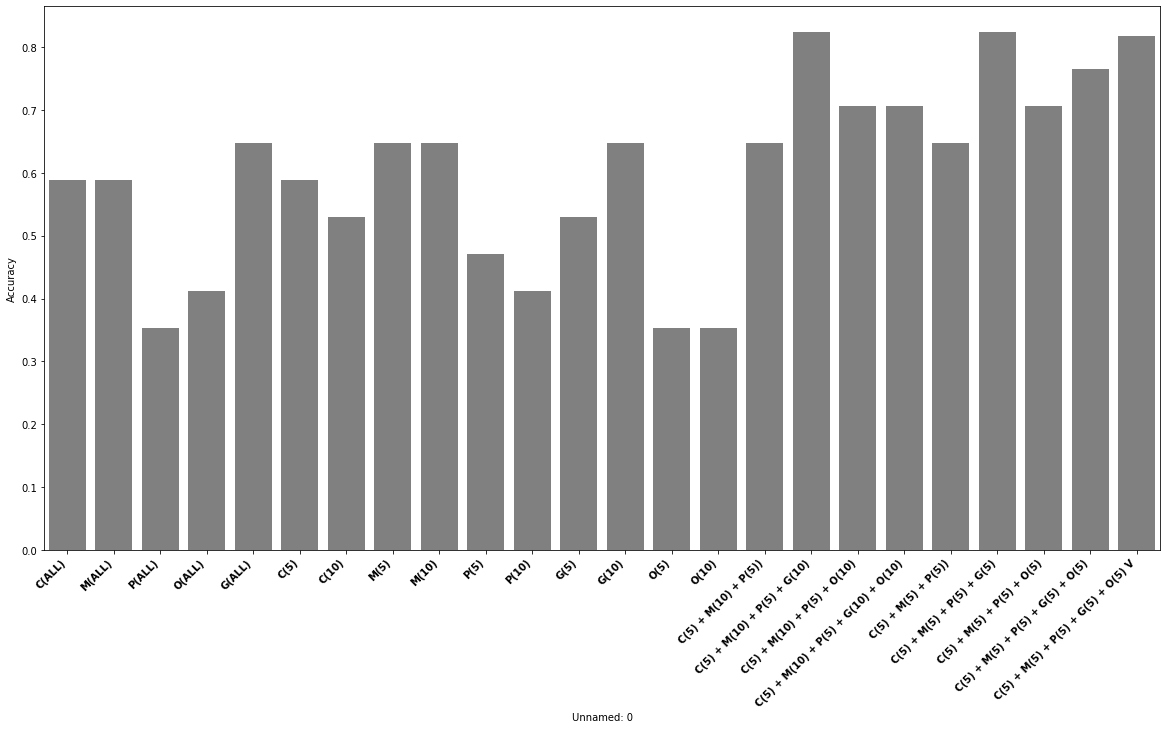

In [10]:
temp = pd.read_csv('../ResultsPaper/Figures/ROC/Accuracy.txt',sep = '\t')
temp.loc[23] = ['C(5) + M(5) + P(5) + G(5) + O(5) V',0.818182]+[0]*5
plt.figure(figsize = (20,10))
g = sns.barplot(data = temp, x = 'Unnamed: 0', y = 'Accuracy',color = 'gray')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight = 'bold')
plt.savefig('../ResultsPaper/Figures/Figure 6A.pdf')

## Figure 6F

In [ ]:
temp1 = pd.read_excel('../ResultsPaper/DS/Supplementary Dataset 15N.xlsx',index_col = 0, sheet_name='C(5)+M(5)+P(5)+G(5)+O(5)')
plt.figure(figsize = (10,7.5))
temp1[i] = ['[*] ' + i if temp1.loc[i]['P value (Severe vs None)'] < 0.05 else i for i in temp1.index]
sns.barplot(data = temp1, y = i, x = 'Importance',color = 'gray')
plt.ylabel('')
plt.xlabel('Feature Importance')
plt.savefig('../ResultsPaper/Figures/Figure 6F.pdf')

## Figure S6 + S7

In [ ]:
temp.sheet_names

In [ ]:
temp = pd.ExcelFile('../ResultsPaper/DS/Supplementary Dataset 15N.xlsx')
# temp.sheet_names
for i in temp.sheet_names[0:5]:
    plt.figure(figsize = (10,7.5))
    if i != 'Combinations':
        temp1 = temp.parse(i,index_col = 0).iloc[0:20,0:]
    else:
        temp1 = temp.parse(i,index_col = 0).iloc[0:20,0:]
    temp1[i] = ['[*] ' + i if temp1.loc[i]['P value (Severe vs None)'] < 0.05 else i for i in temp1.index]
    sns.barplot(data = temp1, y = i, x = 'Importance',color = 'gray')
    plt.ylabel('')
    plt.xlabel('Feature Importance')
    plt.savefig('../ResultsPaper/Figures/RF_%s.pdf' % i)